<a href="https://colab.research.google.com/github/mz-zarei/TextCategorization/blob/main/DecisionTreeAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from operator import itemgetter
import copy 

In [ ]:
trainData = pd.DataFrame(pd.read_csv("trainData.txt", header=None, delimiter=" "))
trainData.columns = ['docID', 'wordID']

trainLabel = pd.read_csv("trainLabel.txt", header=None, delimiter=" ")
trainLabel.columns = ['label']

testData = pd.DataFrame(pd.read_csv("testData.txt", header=None, delimiter=" "))
testData.columns = ['docID', 'wordID']

testLabel = pd.read_csv("testLabel.txt", header=None, delimiter=" ")
testLabel.columns = ['label']


# reforming data so that X have 6968 features with value of either 0 or 1

def reform_data(Data, Label, feature_num):
    X_train = []
    

    for docID in range(1, len(Label)+1):
        X_train.append(Data[Data['docID'] == docID].values[:,1].tolist())
    
    X_sparsed = []

    for i in X_train:
        sparsed_i = []
        for j in range(1,feature_num+1):
            if j in i:
                sparsed_i.append(1)
            else:
                sparsed_i.append(0)
        X_sparsed.append(sparsed_i)
    
    y = Label.values[:,0].tolist()
    X =  X_sparsed
    
    return X, y, X_train

X_train, y_train, X_train_unsparsed = reform_data(trainData, trainLabel, 6968)
X_test, y_test, X_test_unsparsed = reform_data(testData, testLabel, 6968)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))


1500 1500
1500 1500


In [ ]:
####  Functions


def split_data(X_sparsed, y, feature):
    X1 = []
    X2 = []
    y1 = []
    y2 = []
    for X_sample, y_sample in zip(X_sparsed,y):
        if X_sample[feature - 1] == 1:
            X1.append(X_sample)
            y1.append(y_sample)
        else:
            X2.append(X_sample)
            y2.append(y_sample)
    return X1, X2, y1, y2





def weighted_info_gain(y1, y2): #y1 y2 should be list not np array
    
    ### function for computing enthropy
    def info(x):
        if x.count(1) == 0:
            I1=0
        else:
            I1 = -x.count(1)/len(x)*np.log(x.count(1)/len(x))

        if x.count(2) == 0:
            I2=0
        else:
            I2 = -x.count(2)/len(x)*np.log(x.count(2)/len(x))
        return I1 + I2
    
    if len(y1)==0 or len(y2)==0:
        return 0
    else:
        y = y1 + y2
        G = info(y) - ( len(y1)/len(y) * info(y1) + len(y2)/len(y) * info(y2) )
        return G


def avg_info_gain(y1, y2): #y1 y2 should be list not np array
    
    ### function for computing enthropy
    def info(x):
        if x.count(1) == 0:
            I1=0
        else:
            I1 = -x.count(1)/len(x)*np.log(x.count(1)/len(x))

        if x.count(2) == 0:
            I2=0
        else:
            I2 = -x.count(2)/len(x)*np.log(x.count(2)/len(x))
        return I1 + I2
    
    if len(y1)==0 or len(y2)==0:
        return 0
    else:
        y = y1 + y2
        G = info(y) - ( 0.5 * info(y1) + 0.5 * info(y2) )
        return G




def find_best_feature(X, y, feature_list):
    G_best_feature = 0
    for feature in feature_list: 
        X1, X2, y1, y2 = split_data(X, y, feature)
        G = weighted_info_gain(y1, y2)
        if G >= G_best_feature:
            G_best_feature = G
            best_feature = feature
            split_1 = X1
            split_2 = X2
            label_split_1 = y1
            label_split_2 = y2
    return [X,     y     , best_feature, G_best_feature, point_estimate(y), split_1, split_2, label_split_1, label_split_2]




def point_estimate(y):
    if y.count(1) >= y.count(2):
        return "atheism"
    else:
        return "books"




# prepare DT for prediction
def index_DT(DT):
    DT_indexed = copy.deepcopy(DT)
    for i in DT_indexed:
        for j in DT_indexed:
            if i[5] == j[0]:
                i[5] = DT_indexed.index(j)
            if i[6] == j[0]:
                i[6] = DT_indexed.index(j)
        if isinstance(i[5], list):
            i[5] = point_estimate(i[7])
        if isinstance(i[6], list):
            i[6] = point_estimate(i[8])
    return DT_indexed





def predict(DT_indexed, Xlist):
    y_pred = []
    for X in Xlist:
        i = DT_indexed[0]
        condition = True

        while condition == True:
            if i[2] in X:
                if isinstance(i[5], int):
                    i = DT_indexed[i[5]]
                else:
                    y_pred.append(i[5])
                    condition = False
            else:
                if isinstance(i[6], int):
                    i = DT_indexed[i[6]]
                else:
                    y_pred.append(i[6])
                    condition = False
    return y_pred





def accuracy(y, y_pred):
    new_y = []
    for i in y:
        if i == 1:
            new_y.append('atheism')
        else:
            new_y.append('books')
    
    count = 0
    for i in range(len(new_y)):
        if new_y[i] == y_pred[i]:
            count += 1
    acc = count / len(y) * 100
    return acc


In [ ]:
### using weighted information gain


feature_list = range(1, 6870)
X_unsparsed = X_train_unsparsed
X = X_train
y = y_train


best_of_PQ = find_best_feature(X, y, feature_list)
PQ = []
DT = []
DT.append(best_of_PQ) #DT = [X, y, best feature, Gain, PS(y), index_true, index_false]

train_accuracy_w = []
test_accuracy_w = []


for i in range(100):
    train_acc = accuracy(y, predict(index_DT(DT), X_unsparsed))
    test_acc = accuracy(y_test, predict(index_DT(DT), X_test_unsparsed))
    print(i, "node accuracy % train-test: ", train_acc, test_acc)

    train_accuracy_w.append(train_acc)
    test_accuracy_w.append(test_acc)


    first_split = find_best_feature(best_of_PQ[5], best_of_PQ[7], feature_list)
    if first_split[3] != 0:
        PQ.append(first_split)
    
    
    second_split = find_best_feature(best_of_PQ[6], best_of_PQ[8], feature_list)   
    if second_split[3] != 0:     
        PQ.append(second_split)


    PQ = sorted(PQ, key = itemgetter(3), reverse = True)
    if len(PQ) != 0.0:
        best_of_PQ = PQ.pop(0)
        DT.append(best_of_PQ)


0 node accuracy % train-test:  59.13333333333334 58.13333333333334
1 node accuracy % train-test:  59.4 58.199999999999996
2 node accuracy % train-test:  59.53333333333334 58.06666666666666
3 node accuracy % train-test:  64.66666666666666 63.0
4 node accuracy % train-test:  64.73333333333333 62.8
5 node accuracy % train-test:  64.8 63.0
6 node accuracy % train-test:  64.86666666666666 63.0
7 node accuracy % train-test:  64.86666666666666 62.66666666666667
8 node accuracy % train-test:  65.0 62.866666666666674
9 node accuracy % train-test:  65.06666666666666 62.866666666666674
10 node accuracy % train-test:  65.06666666666666 62.866666666666674
11 node accuracy % train-test:  65.13333333333333 62.866666666666674
12 node accuracy % train-test:  65.13333333333333 62.866666666666674
13 node accuracy % train-test:  65.26666666666667 62.866666666666674
14 node accuracy % train-test:  65.4 62.866666666666674
15 node accuracy % train-test:  67.86666666666666 66.06666666666666
16 node accuracy %

<Figure size 1440x720 with 0 Axes>

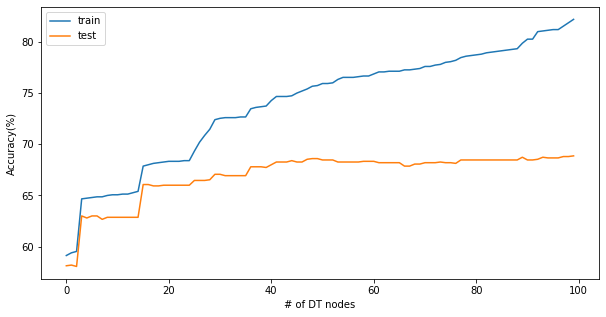

<Figure size 1440x720 with 0 Axes>

In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline  
plt.figure(figsize=(10,5)) 

plt.plot(range(100), train_accuracy_w)
plt.plot(range(100), test_accuracy_w)
plt.legend(['train','test'], loc = 'upper left')
plt.xlabel("# of DT nodes")
plt.ylabel("Accuracy(%)")
plt.figure(figsize=(20,10))


In [ ]:
### using average information gain
def find_best_feature(X, y, feature_list):
    G_best_feature = 0
    for feature in feature_list: 
        X1, X2, y1, y2 = split_data(X, y, feature)
        G = avg_info_gain(y1, y2)
        if G >= G_best_feature:
            G_best_feature = G
            best_feature = feature
            split_1 = X1
            split_2 = X2
            label_split_1 = y1
            label_split_2 = y2
    return [X,     y     , best_feature, G_best_feature, point_estimate(y), split_1, split_2, label_split_1, label_split_2]


feature_list = range(1, 6870)
X_unsparsed = X_train_unsparsed
X = X_train
y = y_train


best_of_PQ = find_best_feature(X, y, feature_list)
PQ = []
DT = []
DT.append(best_of_PQ) #DT = [X, y, best feature, Gain, PS(y), index_true, index_false]

train_accuracy = []
test_accuracy = []


for i in range(100):
    train_acc = accuracy(y, predict(index_DT(DT), X_unsparsed))
    test_acc = accuracy(y_test, predict(index_DT(DT), X_test_unsparsed))
    print(i, "node accuracy % train-test: ", train_acc, test_acc)

    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)


    first_split = find_best_feature(best_of_PQ[5], best_of_PQ[7], feature_list)
    if first_split[3] != 0:
        PQ.append(first_split)
    
    
    second_split = find_best_feature(best_of_PQ[6], best_of_PQ[8], feature_list)   
    if second_split[3] != 0:     
        PQ.append(second_split)


    PQ = sorted(PQ, key = itemgetter(3), reverse = True)
    if len(PQ) != 0.0:
        best_of_PQ = PQ.pop(0)
        DT.append(best_of_PQ)


0 node accuracy % train-test:  52.33333333333333 51.53333333333333
1 node accuracy % train-test:  53.93333333333333 52.2
2 node accuracy % train-test:  55.2 52.86666666666666
3 node accuracy % train-test:  56.46666666666667 53.666666666666664
4 node accuracy % train-test:  57.266666666666666 54.6
5 node accuracy % train-test:  57.93333333333334 54.800000000000004
6 node accuracy % train-test:  58.4 54.86666666666666
7 node accuracy % train-test:  58.86666666666667 55.06666666666666
8 node accuracy % train-test:  59.266666666666666 55.00000000000001
9 node accuracy % train-test:  59.66666666666667 55.00000000000001
10 node accuracy % train-test:  60.06666666666667 55.06666666666666
11 node accuracy % train-test:  60.4 55.06666666666666
12 node accuracy % train-test:  60.73333333333333 55.06666666666666
13 node accuracy % train-test:  61.06666666666667 55.333333333333336
14 node accuracy % train-test:  61.4 56.00000000000001
15 node accuracy % train-test:  61.66666666666667 56.0000000000

<Figure size 1440x720 with 0 Axes>

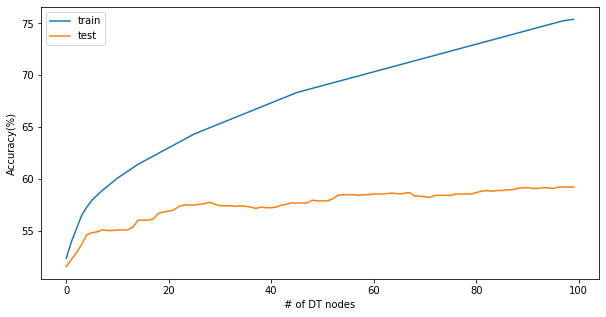

<Figure size 1440x720 with 0 Axes>

In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline  
plt.figure(figsize=(10,5)) 

plt.plot(range(100), train_accuracy)
plt.plot(range(100), test_accuracy)
plt.legend(['train','test'], loc = 'upper left')
plt.xlabel("# of DT nodes")
plt.ylabel("Accuracy(%)")
plt.figure(figsize=(20,10))
